In [1]:
#=======================================
# Libraries
#=======================================
import os
os.environ["OMP_NUM_THREADS"] = "4" # To prevent memory leak from Kmean

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
from kneed import KneeLocator # Automatically detect the elbow point
import pickle # To save the model
import json
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
#======================================================
# Loading the dataset and standardizing the variables
#======================================================

# The directory of the project
basedir = "C:/Users/ilung/Documents/Jedha_bootcamp/capstone_project"

# Loading the dataset
#dataset = pd.read_excel(f"{basedir}/data/clean/complete_data.xlsx")
dataset = pd.read_excel(f"{basedir}/data/clean/france/2022.xlsx")

# Standardizing the pollutants concentration
pollutants = dataset[["no2", "o3", "pm2p5", "pm10", "so2"]]
scaler = StandardScaler()
pollutants_scaled = scaler.fit_transform(pollutants)

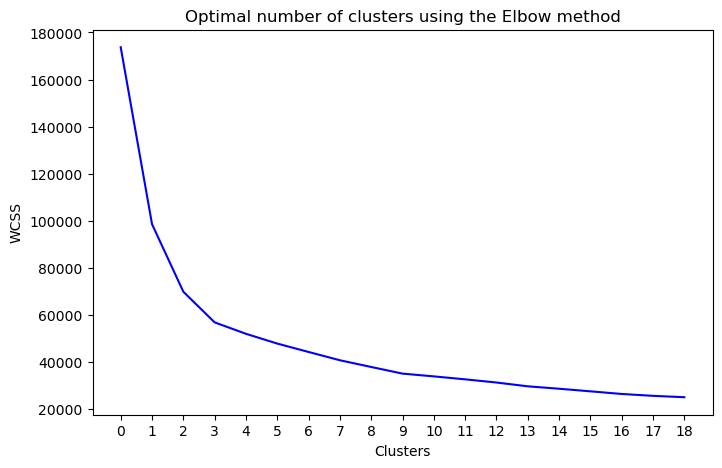

In [3]:
#================================================================
# Finding the optimal number of clusters using the elbow method
#================================================================

wcss =  [] # Within-sum-of-square
k = [] # number of clusters
for i in range (1,20):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(pollutants_scaled)
    wcss.append(kmeans.inertia_)
    k.append(i)

# Plotting the wcss
y = wcss
x = range(len(y))  # Generate indices
plt.figure(figsize=(8, 5))
plt.plot(x, y, linestyle='-', color='b', label='Values')
plt.title("Optimal number of clusters using the Elbow method")
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.xticks(x)  # Set x-axis ticks to correspond to all values in x
plt.show()

In [ ]:
#=========================================
# Running the Kmean
#=========================================

# Applying the KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
dataset["cluster"] = kmeans.fit_predict(pollutants_scaled)

# Evaluating the metrics
labels = dataset["cluster"]
print ("Silhouete score: ", silhouette_score(pollutants_scaled, labels)) # Silhouete score
print("Davies Boulding score: ", davies_bouldin_score(pollutants_scaled, labels)) # Davies Boulding score
print("Calinski Harabasz score: ", calinski_harabasz_score(pollutants_scaled, labels)) # Calinski Harabasz score


Silhouete score:  0.3565090715288646
Davies Boulding score:  0.9566686338518688
Calinski Harabasz score:  25822.921738583704


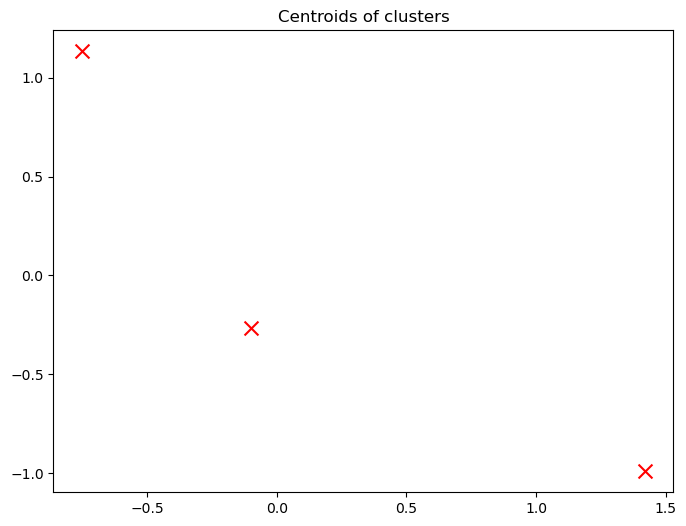

In [5]:
#======================================
# Plotting the centroid
#======================================
plt.figure(figsize=(8, 6))
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], color='red', marker='x', s=100, label='Centroids')
plt.title("Centroids of clusters")
plt.show()

In [ ]:
# Assigning an emission level to each cluster
mapping_dict = {1:"Emissions importantes", 0:"Emissions moyennes", 2:"Emissions faibles"}
dataset["cluster_name"] = dataset["cluster"].map(mapping_dict)

,name,longitude,latitude,no2,pm2p5,pm10,o3,so2,cluster,cluster_name
0,Miraval-Cabardès,2.339825,43.381434,3.597335,7.498323,12.261092,68.380257,0.355697,0,Emissions moyennes
1,Landes-le-Gaulois,1.172074,47.657301,5.830741,8.585693,13.277896,59.362408,0.332835,2,Emissions faibles
2,Égat,2.017666,42.502330,2.259240,7.478992,11.873374,65.073845,0.333868,0,Emissions moyennes
3,Les Ilhes,2.375223,43.357931,3.597335,7.498323,12.261092,68.380257,0.355697,0,Emissions moyennes
4,Waldweistroff,6.495416,49.357529,9.139577,8.467198,14.279904,58.956860,1.615005,1,Emissions importantes
...,...,...,...,...,...,...,...,...,...,...
34741,Sainte-Eulalie,2.380618,45.124423,3.243164,6.574137,10.764052,64.790176,0.200262,0,Emissions moyennes
34742,Chassors,-0.206150,45.710805,5.069142,8.455449,13.857303,56.219807,0.409779,2,Emissions faibles
34743,Balzac,0.133791,45.712202,6.618243,8.580310,13.718887,54.380993,0.406754,2,Emissions faibles
34744,Wattwiller,7.175711,47.841791,9.972743,9.355611,14.369644,62.573864,1.048681,1,Emissions importantes


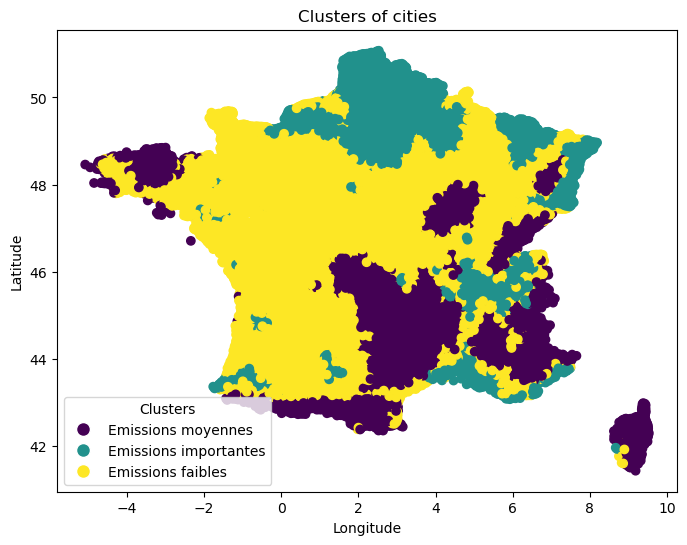

In [8]:
#===========================
# Plotting the results
#==========================
plt.figure(figsize=(8, 6))
scatter = plt.scatter(dataset["longitude"], dataset["latitude"], c=dataset["cluster"], cmap="viridis", marker="o")
plt.title("Clusters of cities")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

legend_labels = [f"Cluster {i}" for i in range(3)] # Legend labels
legend_labels = ["Emissions moyennes", "Emissions importantes", "Emissions faibles"]
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(3)] # Legend symbol

plt.legend(handles, legend_labels, title="Clusters")
plt.show()

#===============================
# Plotting the results on a map
#===============================
#cluster_list = dataset["cluster"].tolist() 
#mapping_list = {1:"Emissions importantes", 0:"Emissions moyennes", 2:"Emissions faibles"}
#name_cluster = [mapping_list[x] for x in cluster_list]
color_map = {
    "Emissions importantes": "red", 
    "Emissions moyennes": "orange", 
    "Emissions faibles": "green"}
category_order = ["Emissions importantes", "Emissions moyennes", "Emissions faibles"]

data = {
    "Latitude": dataset["latitude"].tolist(),
    "Longitude": dataset["longitude"].tolist(),
    "Cluster": dataset["cluster_name"].tolist()
    #"Cluster": dataset["cluster"] .tolist() 
}
cities_map = px.scatter_mapbox(
    data, 
    lat = "Latitude", 
    lon = "Longitude", 
    zoom = 3, 
    color = "Cluster", 
    color_discrete_map = color_map,
    category_orders={"Cluster": category_order},
    mapbox_style='open-street-map'  # Choose map style (e.g., 'carto-positron', 'open-street-map')
)
cities_map.show()

In [10]:
#=========================================
# Quick analysis of the results
#=========================================
# Mapping dictionary
df_average = dataset.groupby("cluster_name", as_index=False)[["no2", "o3", "pm2p5", "pm10", "so2"]].mean()
df_min = dataset.groupby("cluster_name", as_index=False)[["no2", "o3", "pm2p5", "pm10", "so2"]].min()
df_max = dataset.groupby("cluster_name", as_index=False)[["no2", "o3", "pm2p5", "pm10", "so2"]].max()

print ("Here is the average table")
print (df_average)

print ("Here is the table of minimum")
print (df_min)

print ("Here is the table of maximum")
print (df_max)

Here is the average table
            cluster_name       no2         o3     pm2p5       pm10       so2
0      Emissions faibles  5.995290  58.546042  8.505354  13.763002  0.429539
1  Emissions importantes  9.887181  55.356882  9.576148  15.405830  0.831803
2     Emissions moyennes  3.987386  65.964791  7.090488  11.654467  0.343728
Here is the table of minimum
            cluster_name       no2         o3     pm2p5       pm10       so2
0      Emissions faibles  2.531499  49.704960  6.869387  11.632610  0.224173
1  Emissions importantes  4.508045  47.617935  7.074787  11.486062  0.365467
2     Emissions moyennes  1.021564  57.090515  4.986390   8.458266  0.189599
Here is the table of maximum
            cluster_name        no2         o3      pm2p5       pm10       so2
0      Emissions faibles  10.753891  75.489769  10.170688  18.009314  1.576111
1  Emissions importantes  26.082396  75.912239  13.460420  23.561453  5.560041
2     Emissions moyennes   7.638369  82.479744   8.982396  17.5

In [11]:
#=========================================
# Exporting the model and associated file
#=========================================

kmean_model = f"{basedir}/model/kmean_model.pkl"
model_scaler = f"{basedir}/model/scaler.pkl"
table_min = f"{basedir}/model/table_min.xlsx"
table_max = f"{basedir}/model/table_max.xlsx"
table_average = f"{basedir}/model/table_average.xlsx"
final_dataset = f"{basedir}/model/final_dataset.xlsx"

# Saving the model
with open (kmean_model, "wb") as model_file:
    pickle.dump(kmeans,model_file)

# Saving the standard scaler
with open (model_scaler, "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

# Saving the final dataset, the table of minimum, maximum and average
df_average.to_excel(table_average, index=False)
df_max.to_excel(table_max, index=False)
df_min.to_excel(table_min, index=False)
dataset.to_excel(final_dataset, index =False)